In [6]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import gym
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

class Agent(object):
    def __init__(self):
        
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.node_num = 12
        self.learning_rate = 0.0005
        self.model = self.build_model()        

        self.discount_rate = 0.95
        self.penalty = -10
        
        self.episode_num = 1500
        
        self.moving_avg_size = 20
        self.reward_list = []
        self.count_list = []
        self.moving_avg_list = []

        self.states = []
        self.actions = []
        self.rewards = []

    def build_model(self):
        input_states = Input(shape=(self.state_size,), name='input_states') #(1) 입력층 정의
        x = Dense(self.node_num, activation='tanh')(input_states) #(2) 은닉층 정의
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x) #(3) 출력층 정의

        #(4) 모델생성 및 컴파일
        model = tf.keras.models.Model(inputs=input_states, outputs=out_actions)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss='mean_squared_error')
        
        #(5) 모델 구조 요약 및 반환
        model.summary()
        return model

    def train(self):
        #(1) 에피소드 반복 시작
        for episode in range(self.episode_num):
            state, _ = self.env.reset() #(2) 환경을 초기화하고 상태를 받아온다
            step_count = 0
            reward_tot = 0
            done = False

            while not done:
                #(3) 상태에 따라 행동 선택
                state_input = np.reshape(state, [1, self.state_size]).astype(np.float32) 
                policy = self.model(state_input, training=False).numpy()[0]
                action = np.random.choice(self.action_size, p=policy)   #확률적 행동 선택

                #(4) 선택한 행동을 환경에 적용하고 결과를 수집한다
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                if done and step_count < 499:
                    reward = self.penalty

                action_onehot = np.zeros(self.action_size)  #배치학습[a1,a2]->[1,0]으로 넣음 : a1이 선택될 경우
                action_onehot[action] = 1

                #(5) 학습을 위한 데이터 저장
                self.states.append(state)
                self.actions.append(action_onehot)
                self.rewards.append(reward)

                state = next_state
                reward_tot += reward
                step_count += 1

            #(6) 보상 기록 및 이동 평균 계산
            self.reward_list.append(reward_tot - self.penalty)
            self.count_list.append(step_count)
            self.moving_avg_list.append(np.mean(self.reward_list[-self.moving_avg_size:]))

            #(7) 정책 신경망 업데이트(에피소드단위로)
            self.update_model()

            #(8) 메모리 초기화
            self.clear_memory()

            #(9) 학습상태 주기적 출력
            if episode % 10 == 0:
                moving_avg = np.mean(self.reward_list[-self.moving_avg_size:])
                reward_avg = np.mean(self.reward_list)
                print(f"episode:{episode}, moving_avg:{moving_avg:.2f}, rewards_avg:{reward_avg:.2f}")
        #(10) 모델 저장 
        self.save_model()

    def update_model(self):
        #에피소드에서 수집된 값을 전처리(1~3)
        #(1)할인된 누적 보상 계산
        discounted_rewards = self.make_discount_rewards(self.rewards)  
        #(2)상태와 행동 리스트를 배열로 변환
        array_states = np.array(self.states, dtype=np.float32)          
        array_actions = np.array(self.actions, dtype=np.float32)
        #(3)보상을 정규화
        discounted_rewards -= np.mean(discounted_rewards)              
        discounted_rewards /= (np.std(discounted_rewards) + 1e-8)   #표준편차 1로 정규화
        #학습 데이터를 넘겨서 신경망 학습
        self.train_on_batch(array_states, array_actions, discounted_rewards)
    
    #반환값G를 계산한다(R1+rR2+r^2R3...)
    def make_discount_rewards(self, rewards):
		#(1) 할인된 보상을 저장할 배열 생성
        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
		
		#(2) 누적 보상값을 저장할 변수 초기화
        cumulative = 0.0
		
		#(3) 보상 리스트를 뒤에서부터 순회
        for i in reversed(range(len(rewards))):
		
			#(4) 할인율을 적용해 누적 보상 계산
            cumulative = cumulative * self.discount_rate + rewards[i]
			
			#(5) 계산된 누적 보상을 배열에 저장
            discounted_rewards[i] = cumulative
        return discounted_rewards   
    
    #정책 신경망을 학습시키는 실제 학습 단계이며, 수집된 상태, 행동, 보상데이터를 바탕으로 정책을 개선하는 핵심 역할
    def train_on_batch(self, states, actions, rewards):
        with tf.GradientTape() as tape: #(1) 학습준비
            #(2) 현재 정책 확률 분포 계산
            probs = self.model(states, training=True)

            #(3) 선택한 행동의 로그 확률 계산(손실함수를 계산할때 확률이 클수록 손실을 작게, 확률이 작을수록 손실을 크게 만듬)
            log_probs = tf.math.log(tf.reduce_sum(probs * actions, axis=1) + 1e-8)

            #(4) 손실 정의
            loss = -tf.reduce_mean(log_probs * rewards)

        #(5) 파라미터에 대한 기울기(경사) 계산
        gradients = tape.gradient(loss, self.model.trainable_variables)

        #(6) 경사 하강법 통해 모델 업데이트
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    def clear_memory(self):
        self.states, self.actions, self.rewards = [], [], []

    def save_model(self):
        os.makedirs("./model", exist_ok=True)
        self.model.save("./model/reinforce.keras")
        print("*****end learning")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 12)                60        
                                                                 
 output (Dense)              (None, 2)                 26        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
episode:0, moving_avg:10.00, rewards_avg:10.00
episode:10, moving_avg:18.45, rewards_avg:18.45
episode:20, moving_avg:19.80, rewards_avg:19.33
episode:30, moving_avg:18.25, rewards_avg:18.32
episode:40, moving_avg:14.75, rewards_avg:17.10
episode:50, moving_avg:16.70, rewards_avg:17.69
episode:60, moving_avg:19.10, rewards_av

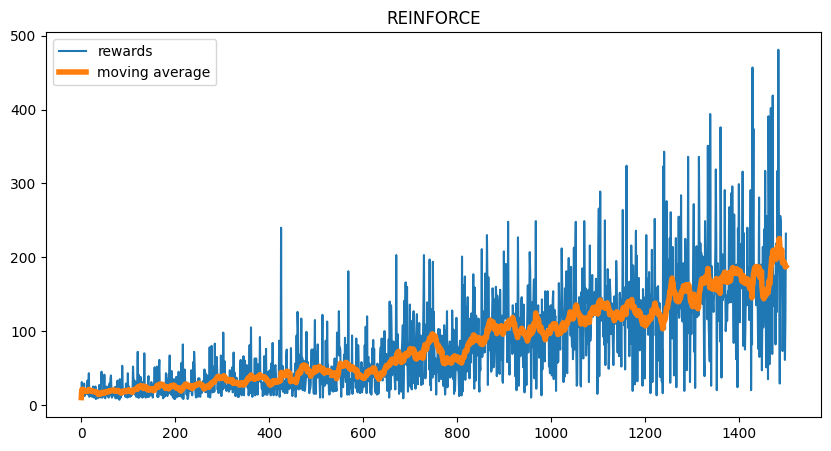

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('REINFORCE')
plt.show()